In [1]:
import tensorflow as ts
import keras
print(ts.__version__)
print(keras.__version__)

Using TensorFlow backend.


2.0.0
2.3.0


In [2]:
import pandas            as pd
import tensorflow        as tf  
import numpy             as np
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models          import Sequential
from keras.layers          import Dense,LSTM,Bidirectional


# 确保结果尽可能重现
from numpy.random          import seed
seed(1)
tf.random.set_seed(1)

# 设置相关参数
n_timestamp  = 40    # 时间戳
n_epochs     = 20    # 训练轮数
# ====================================
#      选择模型：
#            1: 单层 LSTM
#            2: 多层 LSTM
#            3: 双向 LSTM
# ====================================
model_type = 1

In [5]:
data = pd.read_csv('train_data.csv')
data[:5]

,Unnamed: 0,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,0,600519.SH,20211231,2070.0,2072.98,2028.0,2050.00,2075.00,-25.00,-1.2048,29664.91,6.061415e+06
1,1,600519.SH,20211230,2041.0,2088.98,2028.0,2075.00,2041.00,34.00,1.6659,35261.36,7.272867e+06
2,2,600519.SH,20211229,2150.0,2154.25,2041.0,2041.00,2138.18,-97.18,-4.5450,54049.02,1.119563e+07
3,3,600519.SH,20211228,2133.0,2155.50,2116.6,2138.18,2131.82,6.36,0.2983,27650.70,5.901941e+06
4,4,600519.SH,20211227,2168.0,2168.00,2112.0,2131.82,2194.09,-62.27,-2.8381,37555.90,8.020678e+06


In [25]:
data = pd.read_csv('train_data.csv',index_col='trade_date',
                  parse_dates=True)  #以交易时间trade_date为轴
data.sort_index(axis=0,inplace=True)#先用历史数据倒置数据集
data

,Unnamed: 0,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,,
2001-08-27,4864,600519.SH,4.6173,5.0549,4.3952,4.7565,4.1999,0.5566,13.2527,406318.00,1.410347e+06
2001-08-28,4863,600519.SH,4.6816,4.9505,4.6307,4.9318,4.7565,0.1753,3.6855,129647.79,4.634631e+05
2001-08-29,4862,600519.SH,4.9478,4.9505,4.8301,4.8675,4.9318,-0.0643,-1.3038,53252.75,1.946896e+05
2001-08-30,4861,600519.SH,4.8542,5.0187,4.8167,4.9639,4.8675,0.0964,1.9805,48013.06,1.775586e+05
2001-08-31,4860,600519.SH,4.9706,5.0334,4.9237,4.9518,4.9639,-0.0121,-0.2438,23231.48,8.623124e+04
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4,600519.SH,2168.0000,2168.0000,2112.0000,2131.8200,2194.0900,-62.2700,-2.8381,37555.90,8.020678e+06
2021-12-28,3,600519.SH,2133.0000,2155.5000,2116.6000,2138.1800,2131.8200,6.3600,0.2983,27650.70,5.901941e+06
2021-12-29,2,600519.SH,2150.0000,2154.2500,2041.0000,2041.0000,2138.1800,-97.1800,-4.5450,54049.02,1.119563e+07


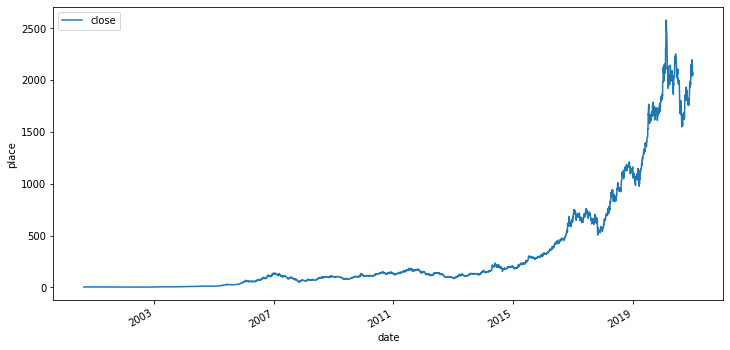

In [33]:
plt.rcParams['figure.figsize']=[12,6]
data['close'].plot()
plt.legend(loc=2)
plt.xlabel('date')
plt.ylabel('place')
plt.show()

In [38]:
"""
前(4865-300)天的开盘价作为训练集,后300天的开盘价作为测试集
"""
training_set = data.iloc[0:4865- 300, 5:6].values  
test_set     = data.iloc[4856 - 300:, 5:6].values

In [39]:
#将数据归一化，范围是0到1
sc  = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled  = sc.transform(test_set) 

In [40]:
# 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train          = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test   = data_split(testing_set_scaled, n_timestamp)
X_test           = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [41]:
# 建构 LSTM模型
if model_type == 1:
    # 单层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu',
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
if model_type == 2:
    # 多层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True,
                   input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # 双向 LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'),
                            input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    
model.summary() # 输出模型结构

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [42]:
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差

In [43]:
history = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=n_epochs, 
                    validation_data=(X_test, y_test), 
                    validation_freq=1)                  #测试的epoch间隔数

model.summary()

Train on 4525 samples, validate on 269 samples
Epoch 1/20
4525/4525 [==============================] - 3s 745us/step - loss: 0.0103 - val_loss: 0.0049
Epoch 2/20
4525/4525 [==============================] - 3s 647us/step - loss: 1.1919e-04 - val_loss: 0.0050
Epoch 3/20
4525/4525 [==============================] - 3s 735us/step - loss: 8.3580e-05 - val_loss: 0.0044
Epoch 4/20
4525/4525 [==============================] - 3s 661us/step - loss: 6.9215e-05 - val_loss: 0.0024
Epoch 5/20
4525/4525 [==============================] - 3s 704us/step - loss: 6.8396e-05 - val_loss: 0.0025
Epoch 6/20
4525/4525 [==============================] - 3s 656us/step - loss: 6.6755e-05 - val_loss: 0.0022
Epoch 7/20
4525/4525 [==============================] - 3s 671us/step - loss: 6.7018e-05 - val_loss: 0.0020
Epoch 8/20
4525/4525 [==============================] - 3s 640us/step - loss: 6.7999e-05 - val_loss: 0.0019
Epoch 9/20
4525/4525 [==============================] - 3s 634us/step - loss: 6.0581e-05 - va

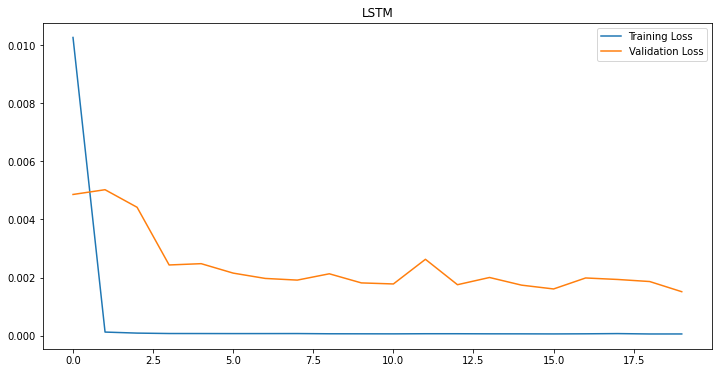

In [44]:
plt.plot(history.history['loss']    , label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM')
plt.legend()
plt.show()     #loss 下降，val_loss 下降：训练网络正常，最理想情况情况,起飞 by liujing

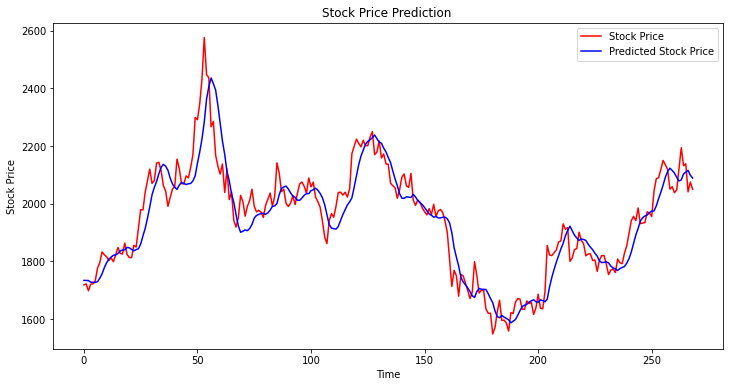

In [45]:
predicted_stock_price = model.predict(X_test)                        # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price      = sc.inverse_transform(y_test)# 对真实数据还原---从（0，1）反归一化到原始范围

# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction ')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [46]:
"""
MSE  ：均方误差    ----->  预测值减真实值求平方后求均值
RMSE ：均方根误差  ----->  对均方误差开方
MAE  ：平均绝对误差----->  预测值减真实值求绝对值后求均值
R2   ：决定系数，可以简单理解为反映模型拟合优度的重要的统计量
结果来看，还阔以。
"""
MSE   = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE  = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE   = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2    = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 4795.65577
均方根误差: 69.25067
平均绝对误差: 50.92914
R2: 0.84739
